In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fluency-nlp/data.tsv


In [5]:
!pip install -U nltk


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [6]:

import pandas as pd
import pandas as pd
import re
import json
from nltk.corpus import stopwords
import nltk
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')

from nltk.util import pad_sequence
from nltk.util import ngrams
from nltk import word_tokenize, sent_tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from sklearn.model_selection import train_test_split
stop_words = stopwords.words('english')
import tensorflow as tf

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:

data  =pd.read_table('/kaggle/input/fluency-nlp/data.tsv',usecols=['Source' , 'Shortening' , 'AverageMeaning','AverageGrammar'])
cdata = data[data['AverageMeaning']<=3 ][data['AverageGrammar']<=3]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [8]:
cdata['fluency'] = 0.2 * cdata['AverageMeaning'] + 0.8 * cdata['AverageGrammar']
cdata['fluency'] = cdata['fluency'].round()

In [9]:
cdata['fluency'].value_counts()

3.0    19374
2.0     3402
1.0      105
Name: fluency, dtype: int64

In [10]:
X = cdata['Shortening']
y = cdata['fluency']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
X_train = list(X_train)
y_train = list(y_train)
X_test = list(X_test)
y_test = list(y_test)


In [12]:
from keras.preprocessing.text import Tokenizer
wordtoken = Tokenizer(oov_token = 1)

In [13]:
tokenized_data = []
tokenized_X  = []
for data in X_train:
    sentences = sent_tokenize(data)
    cursent = []
    for sentence in sentences:
        cursent.extend(word_tokenize(sentence.lower()))
    tokenized_X.append(cursent)


In [14]:
tokenized_testX = []
for data in X_test:
    sentences = sent_tokenize(data)
    cursent = []
    for sentence in sentences:
        cursent.extend(word_tokenize(sentence.lower()))
    tokenized_testX.append(cursent)


In [15]:
wordtoken.fit_on_texts(tokenized_X)

In [16]:
X = wordtoken.texts_to_sequences(tokenized_X)
Xtest = wordtoken.texts_to_sequences(tokenized_testX)

In [17]:
MAX_LEN=50
for x in X:
    MAX_LEN = max(MAX_LEN , len(x))
print(MAX_LEN)

76


In [18]:

X = tf.keras.utils.pad_sequences(X ,maxlen = MAX_LEN, padding = 'pre')
Xtest = tf.keras.utils.pad_sequences(Xtest ,maxlen = MAX_LEN, padding = 'pre')

In [19]:
len(X) , len(y_train) , len(Xtest) , len(y_test)

(15330, 15330, 7551, 7551)

In [65]:
from imblearn.over_sampling import RandomOverSampler, SMOTE ,SVMSMOTE,BorderlineSMOTE,ADASYN
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

samplers = [None , RandomOverSampler , SMOTE,  BorderlineSMOTE,ADASYN]


In [76]:
results_train = []
results_test = []

for idx ,x in enumerate(samplers):
    cX , cy = X ,y_train 
    
    if(x!=None):
        print("trying {} resampler".format(idx))
        sampler = x()
        cX,cy = sampler.fit_resample(cX,cy)
    model = LogisticRegression(random_state=9098,max_iter = 250).fit(cX, cy)
    trainpred = model.predict(cX)
    testpred = model.predict(Xtest)
    print("train accuracy : ", model.score(cX,cy))
    print("test accuracy : ", model.score(Xtest , y_test))
    
    results_train.append([trainpred , cy])
    results_test.append([testpred , y_test])
    clf = make_pipeline(StandardScaler(), SVC(random_state = 100,max_iter = 2500,gamma='auto'))
    model = clf.fit(cX, cy)
    trainpred = model.predict(cX)
    testpred = model.predict(Xtest)
    print("train accuracy : ", model.score(cX,cy))
    print("test accuracy : ", model.score(Xtest , y_test))
    
    results_train.append([trainpred , cy])
    results_test.append([testpred , y_test])
    

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


train accuracy :  0.8495759947814743
test accuracy :  0.8526023043305523


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


train accuracy :  0.8568166992824527
test accuracy :  0.8536617666534234
trying 1 resampler


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


train accuracy :  0.46819024088943795
test accuracy :  0.44643093629982783


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


train accuracy :  0.36751080914144535
test accuracy :  0.839359025294663
trying 2 resampler


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


train accuracy :  0.48870187358451717
test accuracy :  0.5701231624950338


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


train accuracy :  0.3704447189623224
test accuracy :  0.8409482187789696
trying 3 resampler


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


train accuracy :  0.6807185505456043
test accuracy :  0.6054827175208581


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


train accuracy :  0.6681850936792258
test accuracy :  0.829426566017746
trying 4 resampler


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


train accuracy :  0.48987833423360855
test accuracy :  0.5792610250297974


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=2500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


train accuracy :  0.4049180749543432
test accuracy :  0.836842802277844


In [77]:
def print_report(res):
    for idx , x in enumerate(res):
        print(classification_report(x[1] , x[0]))
print_report( results_train )

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        75
         2.0       0.65      0.06      0.12      2303
         3.0       0.85      0.99      0.92     12952

    accuracy                           0.85     15330
   macro avg       0.50      0.35      0.34     15330
weighted avg       0.82      0.85      0.79     15330

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        75
         2.0       0.74      0.12      0.20      2303
         3.0       0.86      0.99      0.92     12952

    accuracy                           0.86     15330
   macro avg       0.53      0.37      0.37     15330
weighted avg       0.84      0.86      0.81     15330

              precision    recall  f1-score   support

         1.0       0.52      0.58      0.55     12952
         2.0       0.42      0.37      0.39     12952
         3.0       0.46      0.46      0.46     12952

    accuracy        

In [70]:
print_report( results_test )

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        30
         2.0       0.59      0.05      0.09      1099
         3.0       0.86      0.99      0.92      6422

    accuracy                           0.85      7551
   macro avg       0.48      0.35      0.34      7551
weighted avg       0.81      0.85      0.80      7551

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00        30
         2.0       0.17      0.35      0.23      1099
         3.0       0.86      0.71      0.78      6422

    accuracy                           0.65      7551
   macro avg       0.34      0.35      0.34      7551
weighted avg       0.76      0.65      0.69      7551

              precision    recall  f1-score   support

         1.0       0.01      0.33      0.01        30
         2.0       0.17      0.35      0.23      1099
         3.0       0.87      0.45      0.60      6422

    accuracy        

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


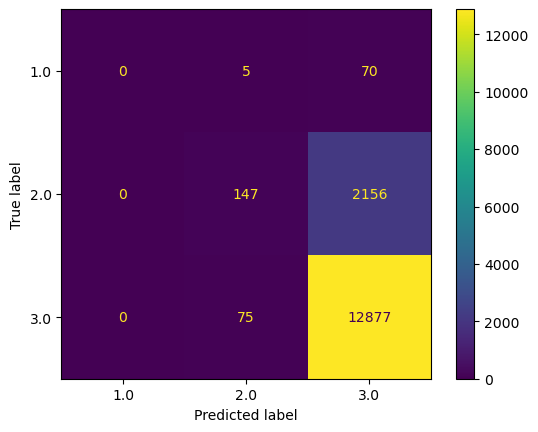

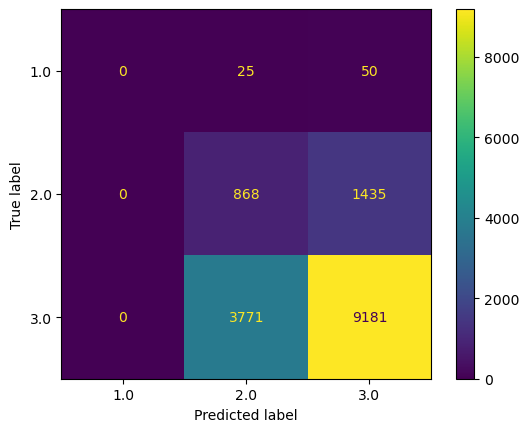

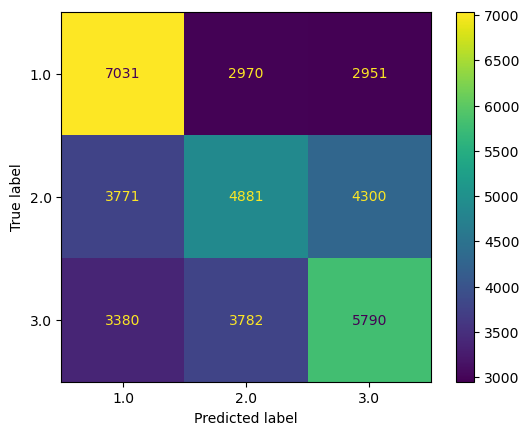

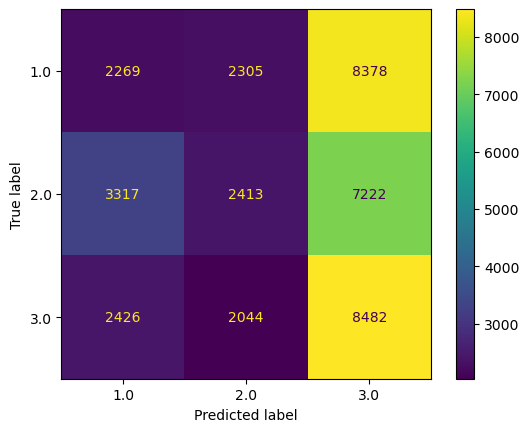

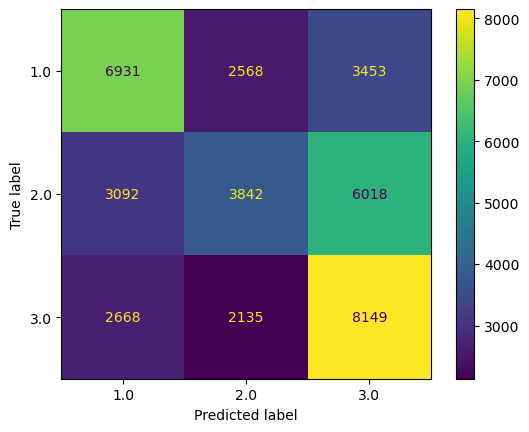

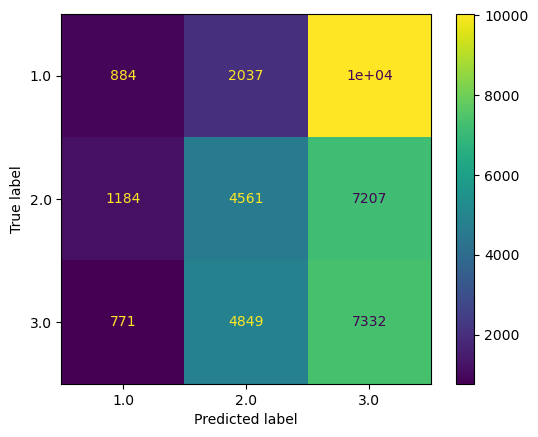

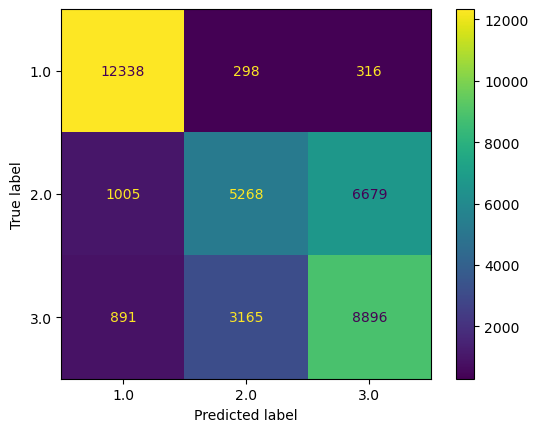

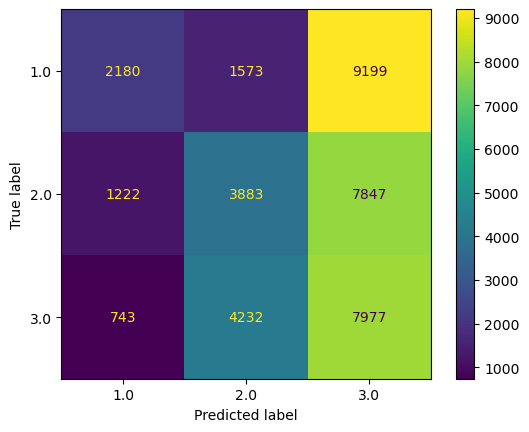

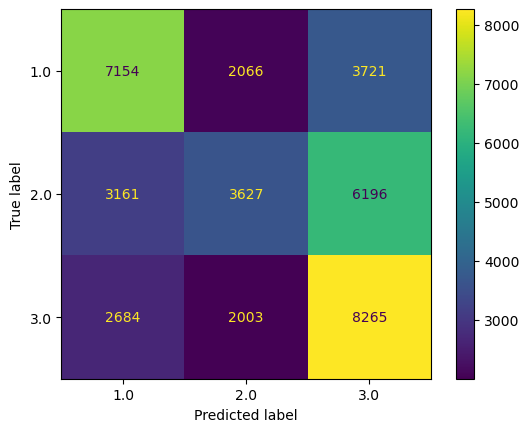

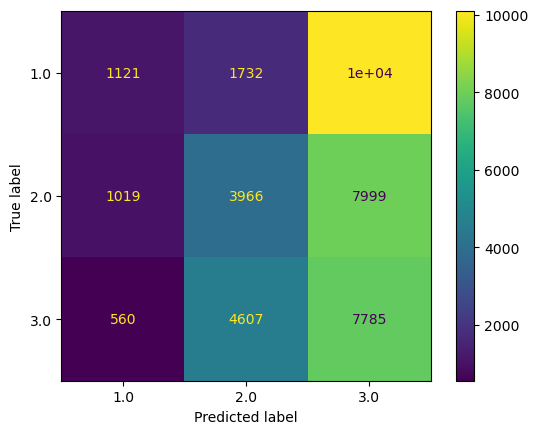

In [72]:
def displayconfusionmatrix(res):
    for x in res:
        ConfusionMatrixDisplay.from_predictions(x[1] ,x[0])
displayconfusionmatrix(results_train)

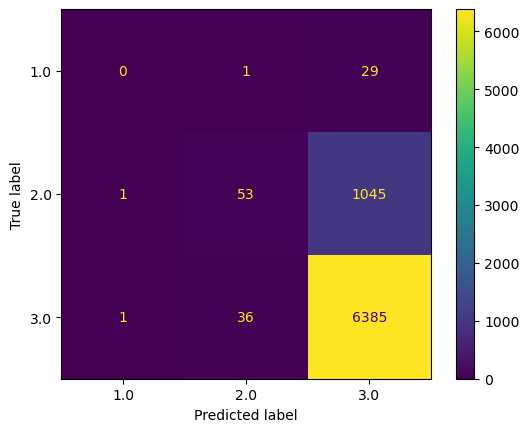

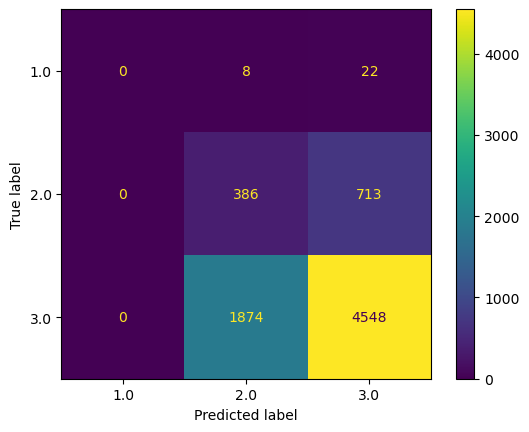

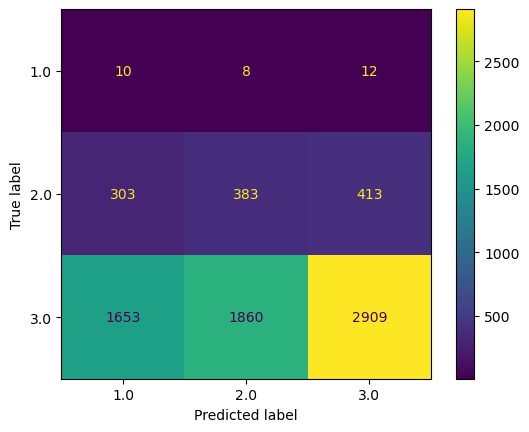

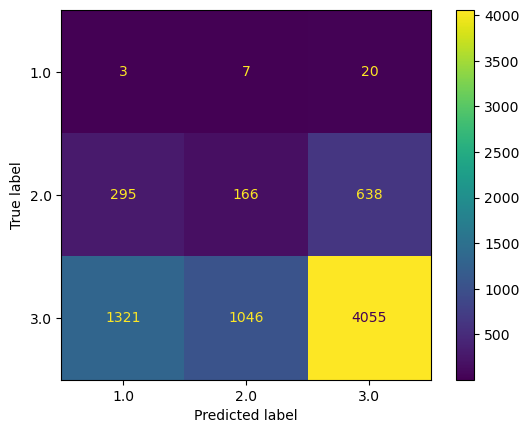

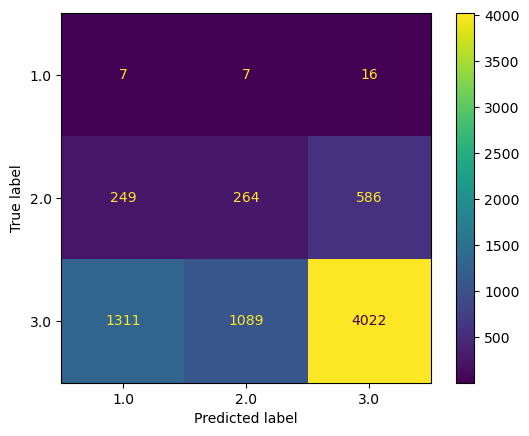

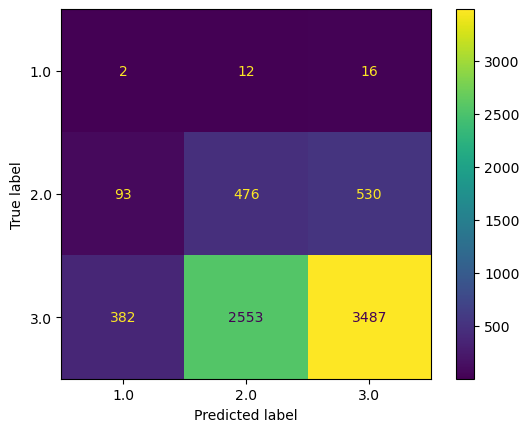

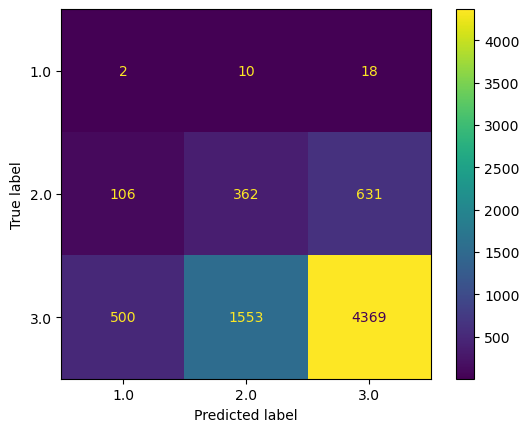

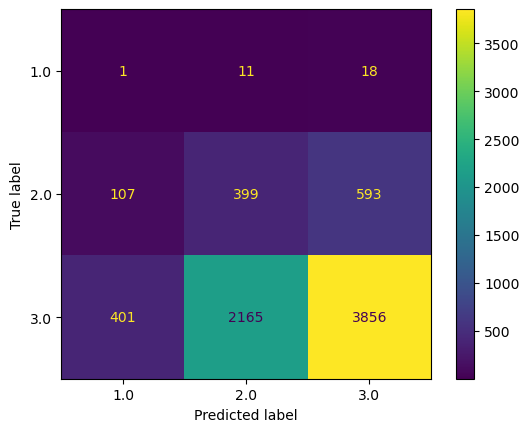

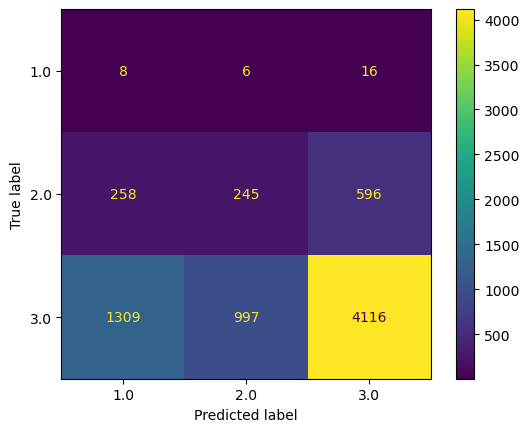

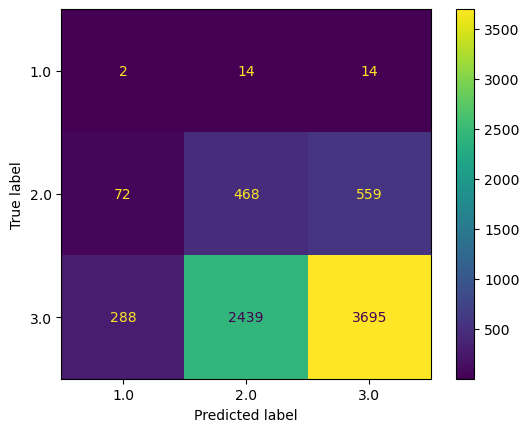

In [73]:
displayconfusionmatrix(results_test)